Jack-Knife error erstimation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import glob
import scipy.odr.odrpack as odrpack
import matplotlib

In [119]:
baryC = False
if baryC is True:
    void_cat = np.loadtxt('/home/icgguest/Desktop/RSD/catalogues/Plane_par_specz_Voids_baryC_cat.txt')
    RedSpdg_cumul = np.load('/home/icgguest/Desktop/RSD/profiles/PP_speczVoidsbaryC_all_speczdg_cumul.npy')
    RedSpdg = np.load('/home/icgguest/Desktop/RSD/profiles/PP_speczVoidsbaryC_all_speczdg.npy')
    
else:
    void_cat = np.loadtxt('/home/icgguest/Desktop/RSD/catalogues/Plane_par_specz_Voids_cat.txt')
    RedSpdg_cumul = np.load('/home/icgguest/Desktop/RSD/profiles/PP_speczVoids_all_speczdg_cumul.npy')
    RedSpdg = np.load('/home/icgguest/Desktop/RSD/profiles/PP_speczVoids_all_speczdg.npy')

rvals = RedSpdg[:,0]
rv_mean = np.mean(void_cat[:,4])
rvals = rvals/rv_mean
RedSpdg = RedSpdg[:,1:]
RedSpdg_cumul = RedSpdg_cumul[:,1:]


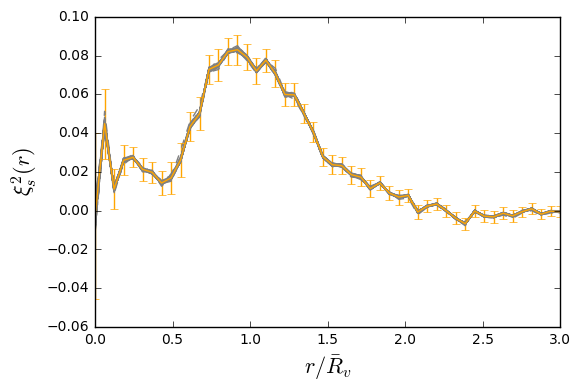

In [111]:
CCF_file = np.loadtxt('/home/icgguest/Desktop/RSD/FULL_CCF/CCFrmu_speczvoids_speczgals.txt')
Files = glob.glob('/home/icgguest/Desktop/JACK_KNIFE/xi_new*.txt')

N = len(Files)
q = np.zeros((N, 50))
count = 0
i = 0
for file in Files:
    df1=np.loadtxt(file)
    r = df1[::60,0]
    xi = df1[:,2].reshape((50,60))
    mu = df1[:60,1]
    P = (1./2)*(3*(mu**2) - 1)
    q[i,:] = 5 * np.trapz(xi*P, mu)
    plt.plot(rvals, q[i,:], 'r--', color = 'grey')
    count +=1
    i +=1
q_mean = np.mean(q, axis = 0)
q_err = np.sqrt(N-1)*np.std(q, axis = 0)

xi_rmu = CCF_file[:,2].reshape(50,60)
x_rmu = CCF_file[::60,0]
y_rmu = CCF_file[:60,1]

P = (1./2)*(3*(y_rmu**2) - 1)
quadrupole = 5 * np.trapz(xi_rmu*P, y_rmu)

plt.errorbar(rvals, quadrupole, yerr = q_err, color = 'orange')
plt.xlabel(r'$r/\bar{R}_{v}$', size = '16')
plt.ylabel(r'$\xi_{s}^{2}(r)$', size = '16')
plt.show()

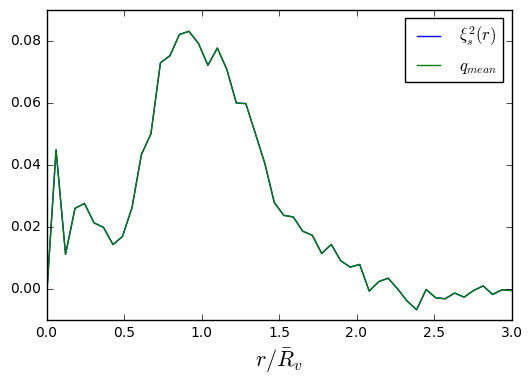

In [109]:
plt.plot(rvals, quadrupole, label = r'$\xi_{s}^{2}(r)$')
plt.plot(rvals, q_mean, label = r'$q_{mean}$')
plt.legend(loc = 1)
plt.xlabel(r'$r/\barR_{v}$', size = '16')
plt.show()

In [120]:
limits = [0.0, 2500./8, 2500./4, 3*2500./8, 2500./2, 5*2500./8, 3*2500./2, 7*2500./8, 2500.]
data_voids = np.loadtxt('/home/icgguest/Desktop/RSD/PP_specz_voids.txt')

m = 0
X = np.zeros((512, 50))
for i in range(8):
    for j in range(8):
        for k in range(8):
            select = (data_voids[:,0] > limits[i]) & (data_voids[:,0]
                            < limits[i + 1]) & (data_voids[:,1]
                                > limits[j]) & (data_voids[:,1]
                                    < limits[j +1]) & (data_voids[:,2]
                                         > limits[k]) & (data_voids[:,2]
                                            < limits[k + 1])
            new_xi = RedSpdg[:,np.logical_not(select)]
            new_xi_bar = RedSpdg_cumul[:,np.logical_not(select)]
            X[m,:] = np.mean(new_xi - new_xi_bar, axis = 1)
            m += 1
X_mean = np.mean(X, axis=0)
X_err = np.sqrt(512-1)*np.std(X, axis=0)

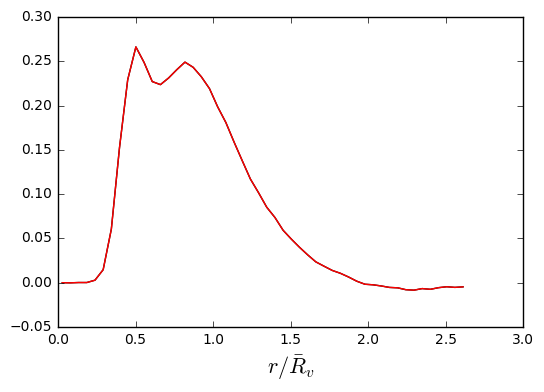

In [121]:
plt.plot(rvals,X_mean, color= 'black')
plt.plot(rvals, np.mean(RedSpdg - RedSpdg_cumul,axis=1), color = 'red')
plt.xlabel(r'$r/\barR_{v}$', size = '16')
plt.show()

Beta: [ 0.50575736]
Beta Std Error: [ 0.03227795]
Beta Covariance: [[ 0.00024259]]
Residual Variance: 4.294690763258383
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


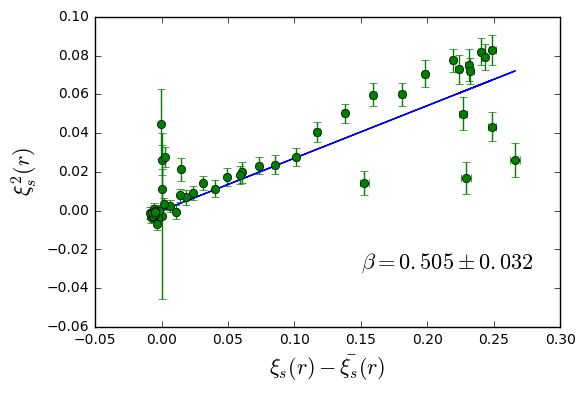

In [199]:
RedSpdg_mean = np.mean(RedSpdg, axis = 1)
RedSpdg_cumul_mean = np.mean(RedSpdg_cumul,axis=1)
xi_diff_red = (RedSpdg_mean - RedSpdg_cumul_mean)

def f(B, x):
    return ((2*B[0])/(3 + B[0])) *x
linear = odrpack.Model(f)

X_err[X_err==0]=1e-99
q_err[q_err==0]=1e-99

mydata = odrpack.RealData(xi_diff_red, quadrupole, sx=X_err, sy= q_err)
                                                                                    
myodr = odrpack.ODR(mydata, linear, beta0 = [0.4])
myoutput = myodr.run()
myoutput.pprint()

def linear(x,m):
    return m*x
popt,pcov = curve_fit(linear, xi_diff_red, quadrupole)
plt.plot(xi_diff_red, linear(xi_diff_red, popt))
plt.annotate(r'$\beta = 0.505 \pm 0.032 $', xy = (0.15, -0.03), size = '16')

plt.errorbar(xi_diff_red, quadrupole, xerr = X_err, yerr = q_err, fmt='o')
plt.xlabel(r'$\xi_{s}(r) - \bar{\xi_{s}}(r)$', size = '16')
plt.ylabel(r'$\xi_{s}^{2}(r)$', size = '16')
plt.show()

In [193]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    cdict = {'red': [],'green': [],'blue': [],'alpha': []}
    reg_index = np.linspace(start, stop, 257)
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap
my_cmap = matplotlib.cm.get_cmap('seismic')
shifted_cmap = shiftedColorMap(my_cmap, midpoint=0.25,  name='shifted')

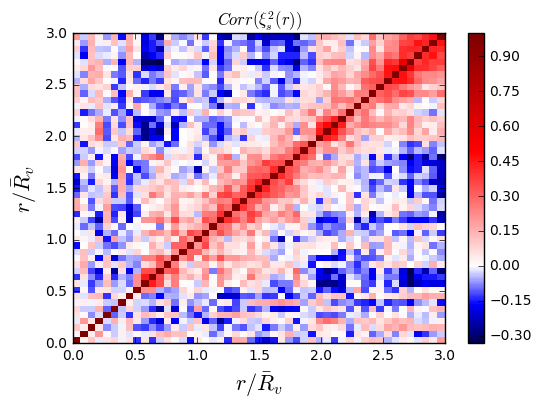

In [179]:
N_r = 50
rvals = np.linspace(0, 3, 50)
cov = np.cov(q - q_mean, rowvar = False)
D = np.sqrt(np.diag(cov))
D[D==0]= 1e-99
corr = np.fromfunction(lambda i,j: cov[i,j]/(D[i]*D[j]), (N_r, N_r), dtype=int)
cs = plt.pcolormesh(rvals,rvals, corr, cmap = shifted_cmap)
plt.colorbar(cs)
plt.xlabel(r'$r/\bar{R}_{v}$', size = '16')
plt.ylabel(r'$r/\bar{R}_{v}$', size = '16')
plt.title(r'$Corr(\xi_{s}^{2}(r))$')
plt.show()

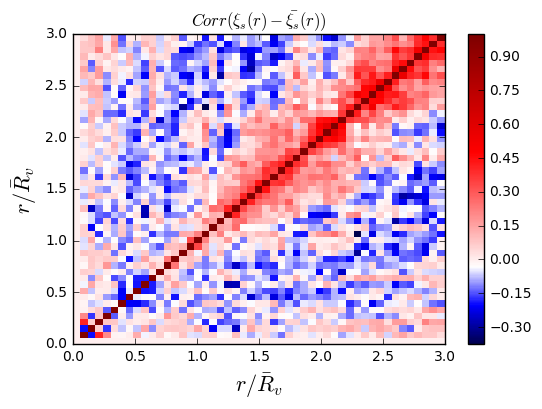

In [146]:
cov = np.cov(X - X_mean, rowvar = False)
rvals = np.linspace(0, 3, 50)
D = np.sqrt(np.diag(cov))
D[D==0]= 1e-99
corr = np.fromfunction(lambda i,j: cov[i,j]/(D[i]*D[j]), (N_r, N_r), dtype=int)
cs = plt.pcolormesh(rvals,rvals,corr, cmap = shifted_cmap)
plt.colorbar(cs)
plt.xlabel(r'$r/\bar{R}_{v}$', size = '16')
plt.ylabel(r'$r/\bar{R}_{v}$', size = '16')
plt.title(r'$Corr(\xi_{s}(r) - \bar{\xi_{s}}(r))$')
plt.show()

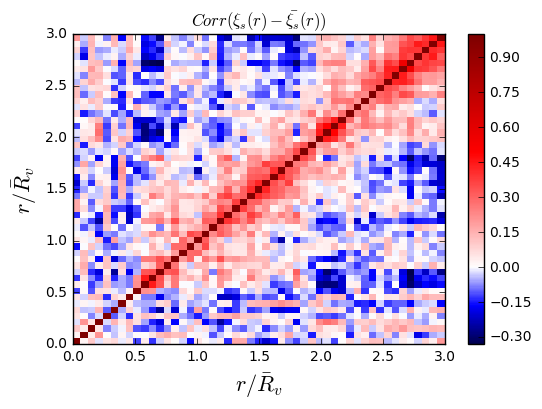

In [197]:
b = 0.396
joint = q - (X * (2*b/(3+b)))
joint_mean = q_mean - (X_mean * (2*b/(3+b)))
cov = np.cov(joint - joint_mean, rowvar = False)
D = np.sqrt(np.diag(cov))
D[D==0]= 1e-99
corr = np.fromfunction(lambda i,j: cov[i,j]/(D[i]*D[j]), (N_r, N_r), dtype=int)
cs = plt.pcolormesh(rvals,rvals,corr, cmap = shifted_cmap)
plt.colorbar(cs)
plt.xlabel(r'$r/\bar{R}_{v}$', size = '16')
plt.ylabel(r'$r/\bar{R}_{v}$', size = '16')
plt.title(r'$Corr(\xi_{s}(r) - \bar{\xi_{s}}(r))$')
plt.show()